In [12]:
! pip install open3d numpy pandas scikit-learn imbalanced-learn xgboost



[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: C:\Users\akhil\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


Processing Two-sided_hip_roof: 100%|██████████| 300/300 [00:00<00:00, 1311.82it/s]
C:\Users\akhil\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:158: UserWarning: [14:54:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Original class distribution: Counter({1: 900, 0: 300})
Class distribution after SMOTE: Counter({0: 900, 1: 900})
Train set size: 1440
Test set size: 360

Classification Report:
              precision    recall  f1-score   support

        Flat       1.00      1.00      1.00       180
    Non-Flat       1.00      1.00      1.00       180

    accuracy                           1.00       360
   macro avg       1.00      1.00      1.00       360
weighted avg       1.00      1.00      1.00       360

Test Accuracy: 1.0


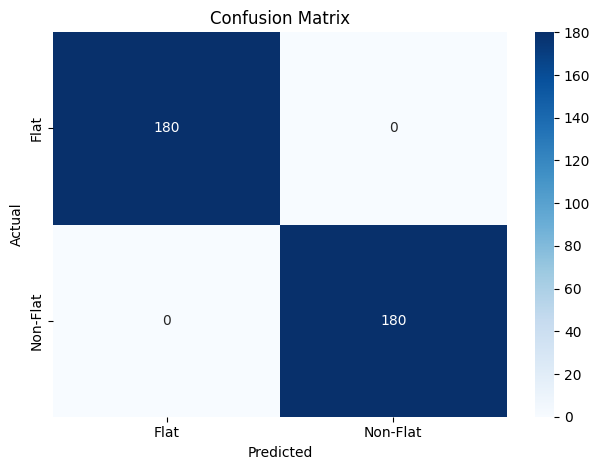

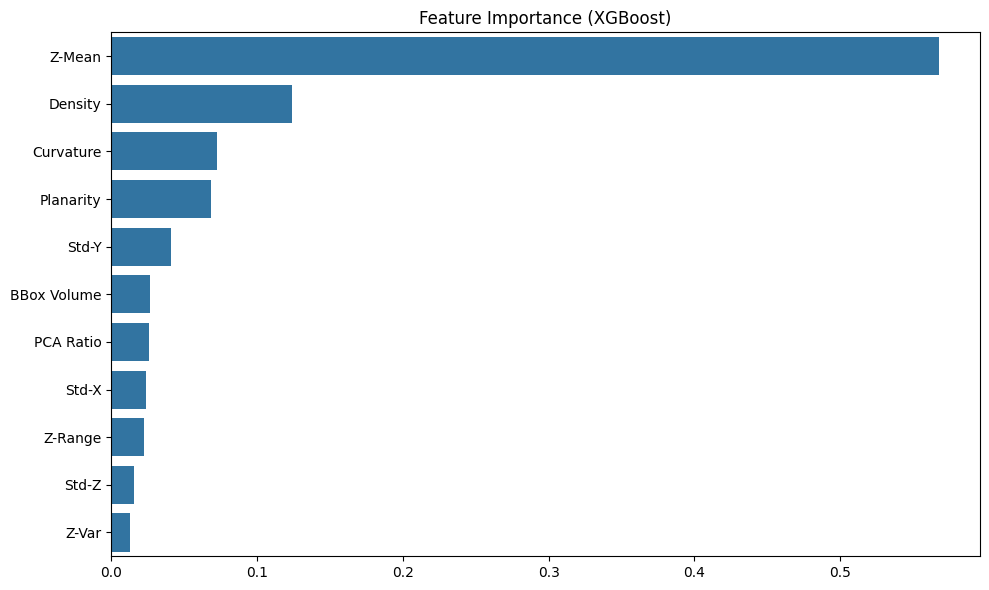


Sample Prediction Probabilities (first 10 test samples):
Sample 0: True=1, Pred=1, Prob=[0.00110561 0.9988944 ]
Sample 1: True=1, Pred=1, Prob=[0.00116259 0.9988374 ]
Sample 2: True=0, Pred=0, Prob=[0.9983251  0.00167488]
Sample 3: True=1, Pred=1, Prob=[8.766055e-04 9.991234e-01]
Sample 4: True=1, Pred=1, Prob=[0.00543827 0.99456173]
Sample 5: True=1, Pred=1, Prob=[0.00920683 0.99079317]
Sample 6: True=1, Pred=1, Prob=[8.9186430e-04 9.9910814e-01]
Sample 7: True=0, Pred=0, Prob=[0.99815625 0.00184374]
Sample 8: True=0, Pred=0, Prob=[0.9904835  0.00951646]
Sample 9: True=1, Pred=1, Prob=[0.0011549 0.9988451]


In [36]:
import os
import numpy as np
import open3d as o3d
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from collections import Counter
import joblib

# ------------------------------ CONFIG ------------------------------
DATASET_PATH = r"C:\Users\akhil\OneDrive\Documents\Building_recon\Roof_type"
classes = {
    "Flat_roof": 0,
    "Pyramid_roof": 1,
    "Saddleback_roof": 1,
    "Two-sided_hip_roof": 1
}

# ------------------------------ FEATURE EXTRACTION ------------------------------
def extract_features(ply_file):
    pcd = o3d.io.read_point_cloud(ply_file)
    points = np.asarray(pcd.points)
    if len(points) == 0:
        return None
    z = points[:, 2]
    height_variance = np.var(z)
    mean_height = np.mean(z)
    z_range = np.max(z) - np.min(z)
    min_bound = np.min(points, axis=0)
    max_bound = np.max(points, axis=0)
    bbox_volume = np.prod(max_bound - min_bound)
    density = len(points) / (bbox_volume + 1e-6)
    cov = np.cov(points.T)
    eigenvalues, _ = np.linalg.eig(cov)
    eigenvalues = np.sort(eigenvalues)[::-1]
    pca_feature = eigenvalues[0] / np.sum(eigenvalues)
    curvature = (eigenvalues[1] - eigenvalues[2]) / (eigenvalues[0] + 1e-6)
    planarity = curvature
    std_xyz = np.std(points, axis=0)
    return [
        height_variance, mean_height, z_range,
        bbox_volume, density,
        pca_feature, curvature, planarity,
        std_xyz[0], std_xyz[1], std_xyz[2]
    ]

# ------------------------------ LOAD & PREPROCESS DATA ------------------------------
X, y = [], []
for label_name, label in classes.items():
    folder_path = os.path.join(DATASET_PATH, label_name)
    if os.path.exists(folder_path):
        for file in tqdm(os.listdir(folder_path), desc=f"Processing {label_name}"):
            if file.endswith(".ply"):
                file_path = os.path.join(folder_path, file)
                features = extract_features(file_path)
                if features is not None:
                    X.append(features)
                    y.append(label)

X, y = np.array(X), np.array(y)
print("Original class distribution:", Counter(y))
if len(X) == 0:
    raise ValueError("❌ No valid features extracted from dataset.")

# ------------------------------ BALANCE DATA WITH SMOTE ------------------------------
smote = SMOTE(random_state=42)
X_bal, y_bal = smote.fit_resample(X, y)
print("Class distribution after SMOTE:", Counter(y_bal))

# ------------------------------ SPLIT TRAIN/TEST ------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X_bal, y_bal, test_size=0.2, stratify=y_bal, random_state=42
)
print(f"Train set size: {len(X_train)}")
print(f"Test set size: {len(X_test)}")

# ------------------------------ XGBOOST TRAINING ------------------------------
model = XGBClassifier(
    n_estimators=200,
    max_depth=6,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0.5,
    reg_lambda=1.0,
    use_label_encoder=False,
    eval_metric="logloss",
    random_state=42
)
model.fit(X_train, y_train)
joblib.dump(model, "xgb_roof_model.pkl")

# ------------------------------ EVALUATE ON TEST SET ------------------------------
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=["Flat", "Non-Flat"]))
print("Test Accuracy:", accuracy_score(y_test, y_pred))

# ------------------------------ CONFUSION MATRIX ------------------------------
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Flat", "Non-Flat"], yticklabels=["Flat", "Non-Flat"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

# ------------------------------ FEATURE IMPORTANCE ------------------------------
feature_names = [
    "Z-Var", "Z-Mean", "Z-Range", "BBox Volume", "Density",
    "PCA Ratio", "Curvature", "Planarity",
    "Std-X", "Std-Y", "Std-Z"
]
importances = model.feature_importances_
sorted_idx = np.argsort(importances)[::-1]

plt.figure(figsize=(10, 6))
sns.barplot(x=importances[sorted_idx], y=[feature_names[i] for i in sorted_idx])
plt.title("Feature Importance (XGBoost)")
plt.tight_layout()
plt.show()

# ------------------------------ SAMPLE PREDICTIONS ------------------------------
print("\nSample Prediction Probabilities (first 10 test samples):")
for i in range(min(10, len(X_test))):
    print(f"Sample {i}: True={y_test[i]}, Pred={y_pred[i]}, Prob={y_prob[i]}")




Processing Two-sided_hip_roof: 100%|██████████| 300/300 [00:00<00:00, 3262.57it/s]
C:\Users\akhil\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:158: UserWarning: [13:37:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Random Forest Results:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        60
           1       1.00      1.00      1.00       180

    accuracy                           1.00       240
   macro avg       1.00      1.00      1.00       240
weighted avg       1.00      1.00      1.00       240

Accuracy: 1.0


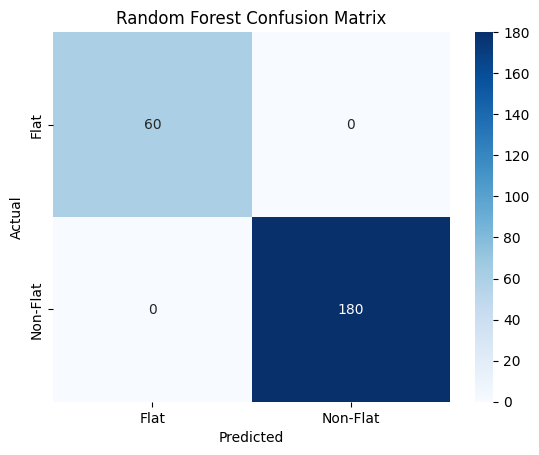


XGBoost Results:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        60
           1       1.00      1.00      1.00       180

    accuracy                           1.00       240
   macro avg       1.00      1.00      1.00       240
weighted avg       1.00      1.00      1.00       240

Accuracy: 1.0


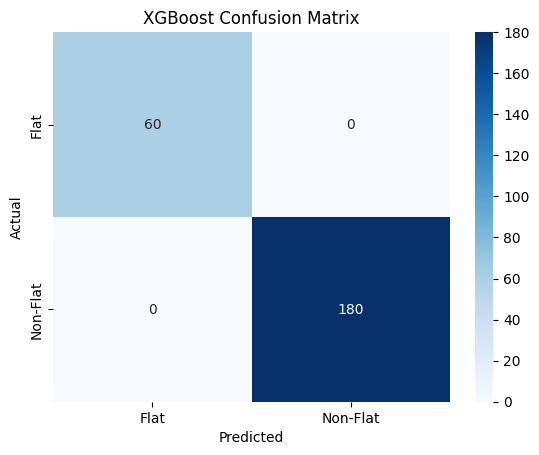

Models saved successfully.


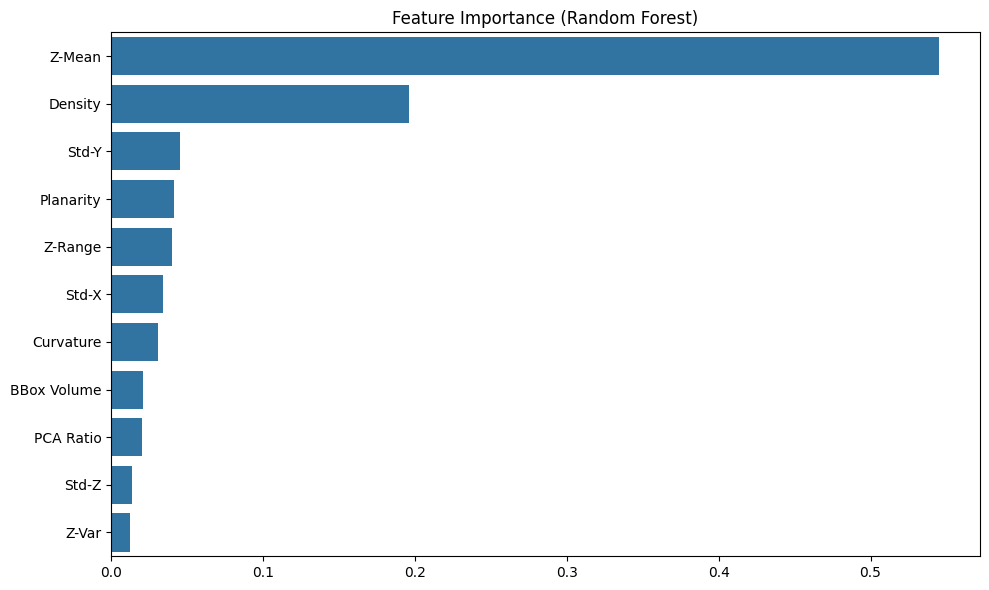

In [3]:
import os
import numpy as np
import open3d as o3d
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from imblearn.combine import SMOTETomek
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import joblib

# Path to dataset folder
DATASET_PATH = r"C:\Users\akhil\OneDrive\Documents\Building_recon\Roof_type"

classes = {
    "Flat_roof": 0,
    "Pyramid_roof": 1,
    "Saddleback_roof": 1,
    "Two-sided_hip_roof": 1
}

# Feature extraction function
def extract_features(ply_file):
    pcd = o3d.io.read_point_cloud(ply_file)
    points = np.asarray(pcd.points)
    if len(points) == 0:
        return None

    # Z values
    z = points[:, 2]
    height_variance = np.var(z)
    mean_height = np.mean(z)
    z_range = np.max(z) - np.min(z)

    # Bounding box
    min_bound = np.min(points, axis=0)
    max_bound = np.max(points, axis=0)
    bbox_volume = np.prod(max_bound - min_bound)
    density = len(points) / (bbox_volume + 1e-6)  # prevent div by zero

    # PCA-based features
    cov = np.cov(points.T)
    eigenvalues, _ = np.linalg.eig(cov)
    eigenvalues = np.sort(eigenvalues)[::-1]  # descending
    pca_feature = eigenvalues[0] / np.sum(eigenvalues)
    curvature = (eigenvalues[1] - eigenvalues[2]) / (eigenvalues[0] + 1e-6)
    planarity = (eigenvalues[1] - eigenvalues[2]) / (eigenvalues[0] + 1e-6)

    # Std deviation
    std_xyz = np.std(points, axis=0)

    return [
        height_variance, mean_height, z_range,
        bbox_volume, density,
        pca_feature, curvature, planarity,
        std_xyz[0], std_xyz[1], std_xyz[2]
    ]

# Load dataset
X, y = [], []

for label_name, label in classes.items():
    folder_path = os.path.join(DATASET_PATH, label_name)
    if os.path.exists(folder_path):
        for file in tqdm(os.listdir(folder_path), desc=f"Processing {label_name}"):
            if file.endswith(".ply"):
                file_path = os.path.join(folder_path, file)
                features = extract_features(file_path)
                if features:
                    X.append(features)
                    y.append(label)

X = np.array(X)
y = np.array(y)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# Balance using SMOTE + Tomek Links
smote = SMOTETomek(random_state=42)
X_train_bal, y_train_bal = smote.fit_resample(X_train, y_train)

# Train Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_bal, y_train_bal)
rf_pred = rf.predict(X_test)

# Train XGBoost
xgb = XGBClassifier(n_estimators=100, use_label_encoder=False, eval_metric='logloss')
xgb.fit(X_train_bal, y_train_bal)
xgb_pred = xgb.predict(X_test)

# Evaluation
def evaluate_model(name, y_true, y_pred):
    print(f"\n{name} Results:")
    print(classification_report(y_true, y_pred))
    print("Accuracy:", accuracy_score(y_true, y_pred))
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Flat', 'Non-Flat'], yticklabels=['Flat', 'Non-Flat'])
    plt.title(f"{name} Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

evaluate_model("Random Forest", y_test, rf_pred)
evaluate_model("XGBoost", y_test, xgb_pred)
# Save the trained models
joblib.dump(rf, 'random_forest_model.pkl')
joblib.dump(xgb, 'xgboost_model.pkl')
print("Models saved successfully.")

# Feature Importance Plot
feature_names = [
    "Z-Var", "Z-Mean", "Z-Range", "BBox Volume", "Density",
    "PCA Ratio", "Curvature", "Planarity",
    "Std-X", "Std-Y", "Std-Z"
]
importances = rf.feature_importances_
sorted_idx = np.argsort(importances)[::-1]

plt.figure(figsize=(10, 6))
sns.barplot(x=importances[sorted_idx], y=[feature_names[i] for i in sorted_idx])
plt.title("Feature Importance (Random Forest)")
plt.tight_layout()
plt.show()


In [16]:
import os
import numpy as np
import open3d as o3d
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, accuracy_score
from imblearn.over_sampling import SMOTE
from tqdm import tqdm

# Path to dataset folder
DATASET_PATH = r"C:\Users\akhil\OneDrive\Documents\Building_recon\Roof_type"

# Define classes
classes = {
    "Flat_roof": 0,  # Flat
    "Pyramid_roof": 1,  # Non-flat
    "Saddleback_roof": 1,  # Non-flat
    "Two-sided_hip_roof": 1  # Non-flat
}

# Feature extraction function
def extract_features(ply_file):
    pcd = o3d.io.read_point_cloud(ply_file)
    points = np.asarray(pcd.points)

    if len(points) == 0:
        return None  # Skip empty point clouds

    # Height variance (Z-axis)
    height_variance = np.var(points[:, 2])

    # PCA-based normal estimation (First Eigenvalue)
    cov_matrix = np.cov(points.T)
    eigenvalues, _ = np.linalg.eig(cov_matrix)
    pca_feature = eigenvalues[0] / np.sum(eigenvalues)

    # Curvature estimation (Difference between largest and smallest eigenvalues)
    curvature = (eigenvalues[1] - eigenvalues[2]) / eigenvalues[0]

    return [height_variance, pca_feature, curvature]

# Load dataset
X, y = [], []

for label, binary_label in classes.items():
    folder_path = os.path.join(DATASET_PATH, label)
    if os.path.exists(folder_path):
        for file in tqdm(os.listdir(folder_path), desc=f"Processing {label}"):
            if file.endswith(".ply"):
                file_path = os.path.join(folder_path, file)
                features = extract_features(file_path)
                if features:
                    X.append(features)
                    y.append(binary_label)

X = np.array(X)
y = np.array(y)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Handle class imbalance using SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Train Random Forest Classifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_resampled, y_train_resampled)
y_pred_rf = rf_model.predict(X_test)

# Train XGBoost Classifier
xgb_model = XGBClassifier(n_estimators=100, use_label_encoder=False, eval_metric="logloss")
xgb_model.fit(X_train_resampled, y_train_resampled)
y_pred_xgb = xgb_model.predict(X_test)

# Print Evaluation Metrics
print("Random Forest Results:")
print(classification_report(y_test, y_pred_rf))
print("Accuracy:", accuracy_score(y_test, y_pred_rf))

print("\nXGBoost Results:")
print(classification_report(y_test, y_pred_xgb))
print("Accuracy:", accuracy_score(y_test, y_pred_xgb))


Processing Two-sided_hip_roof: 100%|██████████| 300/300 [00:00<00:00, 4293.18it/s]
C:\Users\akhil\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:158: UserWarning: [14:01:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Random Forest Results:
              precision    recall  f1-score   support

           0       0.84      0.90      0.87        60
           1       0.97      0.94      0.96       180

    accuracy                           0.93       240
   macro avg       0.90      0.92      0.91       240
weighted avg       0.94      0.93      0.93       240

Accuracy: 0.9333333333333333

XGBoost Results:
              precision    recall  f1-score   support

           0       0.80      0.95      0.87        60
           1       0.98      0.92      0.95       180

    accuracy                           0.93       240
   macro avg       0.89      0.94      0.91       240
weighted avg       0.94      0.93      0.93       240

Accuracy: 0.9291666666666667


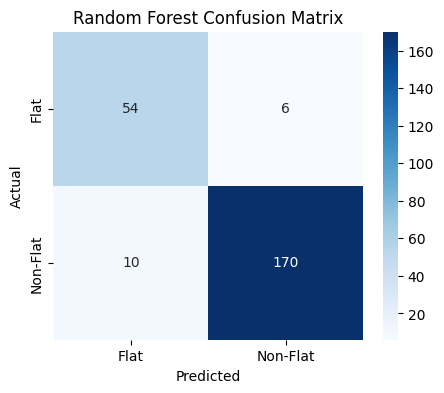

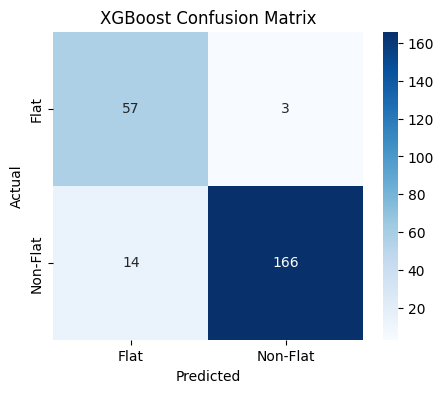

Random Forest Prediction: Non-Flat
XGBoost Prediction: Non-Flat


In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Function to plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Flat", "Non-Flat"], yticklabels=["Flat", "Non-Flat"])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(title)
    plt.show()

# Plot Confusion Matrix
plot_confusion_matrix(y_test, y_pred_rf, "Random Forest Confusion Matrix")
plot_confusion_matrix(y_test, y_pred_xgb, "XGBoost Confusion Matrix")

# Function to predict a new .ply file
def predict_roof_type(ply_file, model):
    features = extract_features(ply_file)
    if features:
        features = np.array(features).reshape(1, -1)  # Reshape for prediction
        prediction = model.predict(features)[0]
        label = "Flat" if prediction == 0 else "Non-Flat"

        # Visualization
        pcd = o3d.io.read_point_cloud(ply_file)
        o3d.visualization.draw_geometries([pcd], window_name=f"Predicted: {label}")

        return label
    else:
        return "Invalid point cloud"

# Test on a random .ply file
test_ply_file = r"C:\Users\akhil\OneDrive\Documents\Building_recon\building_clusters_2\building_2.ply"  # Change to the actual test file path
predicted_label_rf = predict_roof_type(test_ply_file, rf_model)
print(f"Random Forest Prediction: {predicted_label_rf}")

predicted_label_xgb = predict_roof_type(test_ply_file, xgb_model)
print(f"XGBoost Prediction: {predicted_label_xgb}")


In [35]:
import os
import numpy as np
import pandas as pd
import open3d as o3d
import random
import joblib
import open3d.visualization.gui as gui
import open3d.visualization.rendering as rendering

# Load the trained model
rf_model = joblib.load("random_forest_model.pkl")

# Feature extraction - same as training
def extract_features(ply_file):
    pcd = o3d.io.read_point_cloud(ply_file)
    points = np.asarray(pcd.points)
    if len(points) == 0:
        return None

    z = points[:, 2]
    height_variance = np.var(z)
    mean_height = np.mean(z)
    z_range = np.max(z) - np.min(z)

    min_bound = np.min(points, axis=0)
    max_bound = np.max(points, axis=0)
    bbox_volume = np.prod(max_bound - min_bound)
    density = len(points) / (bbox_volume + 1e-6)

    cov = np.cov(points.T)
    eigenvalues, _ = np.linalg.eig(cov)
    eigenvalues = np.sort(eigenvalues)[::-1]
    pca_feature = eigenvalues[0] / np.sum(eigenvalues)
    curvature = (eigenvalues[1] - eigenvalues[2]) / (eigenvalues[0] + 1e-6)
    planarity = (eigenvalues[1] - eigenvalues[2]) / (eigenvalues[0] + 1e-6)

    std_xyz = np.std(points, axis=0)

    return [
        height_variance, mean_height, z_range,
        bbox_volume, density,
        pca_feature, curvature, planarity,
        std_xyz[0], std_xyz[1], std_xyz[2]
    ]

# Prediction for one file
def predict_roof_type(file_path, model):
    features = extract_features(file_path)
    if features:
        features = np.array(features).reshape(1, -1)
        prediction = model.predict(features)[0]
        label_map = {0: "Flat", 1: "Non-Flat"}
        return label_map.get(prediction, "Unknown")
    return None

# Predict all files in folder
def predict_roof_type_batch(folder_path, model):
    results = []
    all_files = [f for f in os.listdir(folder_path) if f.endswith(".ply")]

    for file in all_files:
        file_path = os.path.join(folder_path, file)
        label = predict_roof_type(file_path, model)
        if label:
            results.append({"Filename": file, "Label": label})
        else:
            print(f"⚠️ Skipped invalid point cloud: {file}")
    return results

# Visualization of random results
def visualize_random_predictions(folder_path, predictions, num_samples=5):
    random_files = random.sample(predictions, min(num_samples, len(predictions)))
    for entry in random_files:
        file_path = os.path.join(folder_path, entry["Filename"])
        pcd = o3d.io.read_point_cloud(file_path)
        print(f"🔹 {entry['Filename']} | Predicted: {entry['Label']}")
        o3d.visualization.draw_geometries([pcd], window_name=f"Predicted: {entry['Label']}")

# Path to folder of unseen .ply clusters
BUILDING_CLUSTER_FOLDER = r"C:\Users\akhil\OneDrive\Documents\Building_recon\building_clusters_2"  # 🔸 Change if needed

# Perform batch prediction
predictions = predict_roof_type_batch(BUILDING_CLUSTER_FOLDER, rf_model)

# Save to CSV
df = pd.DataFrame(predictions)
df.to_csv("roof_classification_results_3.csv", index=False)
print("✅ Results saved to roof_classification_results_3.csv")

# Visualize sample results
visualize_random_predictions(BUILDING_CLUSTER_FOLDER, predictions, num_samples=5)




✅ Results saved to roof_classification_results_3.csv
🔹 building_4347.ply | Predicted: Flat
🔹 building_2591.ply | Predicted: Flat
🔹 building_760.ply | Predicted: Flat
🔹 building_465.ply | Predicted: Flat
🔹 building_1067.ply | Predicted: Flat


In [19]:
import open3d as o3d
import numpy as np
import os
import pandas as pd
from shapely.geometry import Polygon
from scipy.spatial import ConvexHull  # ✅ Use SciPy for 2D convex hull

# Define directories
input_dir = r"C:\Users\akhil\OneDrive\Documents\Building_recon\building_clusters_2"  
output_dir = r"C:\Users\akhil\OneDrive\Documents\Building_recon\building_clusters_2" 
os.makedirs(output_dir, exist_ok=True)

# Function to compute building parameters
def compute_building_parameters(pcd, file_id):
    # Extract points
    points = np.asarray(pcd.points)
    
    # Check if there are enough points for convex hull computation
    if len(points) < 4:
        return {
            'id': file_id,
            'area': 0,
            'perimeter': 0,
            'centroid_x': 0,
            'centroid_y': 0,
            'num_points': len(points)
        }
    
    # Project points onto the XY plane
    points_xy = points[:, :2]  
    
    # Compute the 2D convex hull using SciPy
    hull = ConvexHull(points_xy)
    
    # Extract hull vertices
    hull_points = points_xy[hull.vertices]  
    
    # Create a 2D polygon from hull vertices
    polygon = Polygon(hull_points)
    
    # Compute area, perimeter, and centroid
    area = polygon.area
    perimeter = polygon.length
    centroid = polygon.centroid.coords[0]
    
    return {
        'id': file_id,
        'area': area,
        'perimeter': perimeter,
        'centroid_x': centroid[0],
        'centroid_y': centroid[1],
        'num_points': len(points)
    }

# Process all .ply files
building_data = []
for filename in os.listdir(input_dir):
    if filename.endswith(".ply"):
        input_file = os.path.join(input_dir, filename)
        print(f"Processing {filename}...")

        # Load point cloud
        pcd = o3d.io.read_point_cloud(input_file)

        # Compute parameters
        file_id = os.path.splitext(filename)[0]
        building_params = compute_building_parameters(pcd, file_id)

        # Store results
        building_data.append(building_params)

# Convert to DataFrame and save as CSV
building_df = pd.DataFrame(building_data)
output_csv = os.path.join(output_dir, "building_parameters_fixed.csv")
building_df.to_csv(output_csv, index=False)
print(f"Building parameters saved to {output_csv}")


Processing building_1.ply...
Processing building_10.ply...
Processing building_100.ply...
Processing building_1000.ply...
Processing building_1003.ply...
Processing building_101.ply...
Processing building_1019.ply...
Processing building_102.ply...
Processing building_1020.ply...
Processing building_1021.ply...
Processing building_1022.ply...
Processing building_1028.ply...
Processing building_1029.ply...
Processing building_103.ply...
Processing building_1030.ply...
Processing building_1031.ply...
Processing building_1035.ply...
Processing building_1038.ply...
Processing building_1039.ply...
Processing building_104.ply...
Processing building_1040.ply...
Processing building_1042.ply...
Processing building_1044.ply...
Processing building_1046.ply...
Processing building_1047.ply...
Processing building_1049.ply...
Processing building_105.ply...
Processing building_1051.ply...
Processing building_1052.ply...
Processing building_1056.ply...
Processing building_1057.ply...
Processing building

In [20]:
import pandas as pd

# Define the path to your existing CSV file
csv_file_path = r'C:\Users\akhil\OneDrive\Documents\Building_recon\building_clusters_2\building_parameters_fixed.csv'

# Load the existing CSV into a DataFrame
building_df = pd.read_csv(csv_file_path)

In [21]:
import pandas as pd
import os

# Paths
existing_height_csv = r"C:\Users\akhil\OneDrive\Documents\Building_recon\building_cluster_heights.csv"
building_csv = r"C:\Users\akhil\OneDrive\Documents\Building_recon\building_clusters_2\building_parameters_fixed.csv"
csv_file_path = r"C:\Users\akhil\OneDrive\Documents\Building_recon\building_clusters_2\building_parameters_fixed.csv"  # Output path

# Load existing building heights
height_df = pd.read_csv(existing_height_csv)

# Load building clusters
building_df = pd.read_csv(building_csv)

# Merge height data with building IDs
merged_df = building_df.merge(height_df, on="id", how="left")

# Save updated building parameters
merged_df.to_csv(csv_file_path, index=False)

print(f"\n✅ Updated building parameters saved to {csv_file_path}")



✅ Updated building parameters saved to C:\Users\akhil\OneDrive\Documents\Building_recon\building_clusters_2\building_parameters_fixed.csv


In [22]:
import laspy
import numpy as np
import open3d as o3d
import pandas as pd
import os
from scipy.spatial import cKDTree

def get_ground_kdtree(las_path):
    print(f"Reading LAS file: {las_path}")
    las = laspy.read(las_path)
    
    xyz = np.vstack((las.x, las.y, las.z)).T
    classification = np.array(las.classification)
    
    ground_points = xyz[classification == 2]  # Extract ground points
    
    if ground_points.size == 0:
        raise ValueError("⚠️ No ground points found in the LAS file!")
    
    lower, upper = np.percentile(ground_points[:, 2], [5, 95])
    ground_points = ground_points[(ground_points[:, 2] >= lower) & (ground_points[:, 2] <= upper)]
    
    ground_tree = cKDTree(ground_points[:, :2])
    print(f"✅ Ground points extracted: {len(ground_points)}")
    print(f"Ground Z Min: {ground_points[:, 2].min():.2f}, Max: {ground_points[:, 2].max():.2f}")
    
    return ground_points, ground_tree

def compute_building_height_kdtree(ply_path, ground_points, ground_tree):
    if not os.path.exists(ply_path):
        print(f"⚠️ File not found: {ply_path}")
        return np.nan

    pcd = o3d.io.read_point_cloud(ply_path)
    if len(pcd.points) == 0:
        print(f"⚠️ Empty point cloud: {ply_path}")
        return np.nan
    
    building_points = np.asarray(pcd.points)
    
    min_x, min_y = np.min(building_points[:, :2], axis=0)
    max_x, max_y = np.max(building_points[:, :2], axis=0)
    
    ground_within_bbox = ground_points[
        (ground_points[:, 0] >= min_x) & (ground_points[:, 0] <= max_x) &
        (ground_points[:, 1] >= min_y) & (ground_points[:, 1] <= max_y)
    ]
    
    if ground_within_bbox.size == 0:
        _, nearest_idx = ground_tree.query(np.mean(building_points[:, :2], axis=0))
        estimated_ground_z = ground_points[nearest_idx, 2]
        print(f"⚠️ No ground in footprint, using nearest ground point for {ply_path}")
    else:
        estimated_ground_z = np.min(ground_within_bbox[:, 2])
    
    building_heights = building_points[:, 2] - estimated_ground_z
    building_heights = np.maximum(building_heights, 1.0)
    final_height = np.max(building_heights)
    
    print(f"🔹 {os.path.basename(ply_path)} | Ground Z: {estimated_ground_z:.2f} | Height: {final_height:.2f}")
    
    return final_height

las_path = r"C:\Users\akhil\OneDrive\Documents\Building_recon\4C_block_1_2.laz"
csv_path = r"C:\Users\akhil\OneDrive\Documents\Building_recon\building_clusters_2\building_parameters_fixed.csv"
output_csv = r"C:\Users\akhil\OneDrive\Documents\Building_recon\building_heights_2.csv"

print("\n🚀 Building KD-Tree for ground points...")
ground_points, ground_tree = get_ground_kdtree(las_path)
print("✅ KD-Tree built successfully!\n")

building_df = pd.read_csv(csv_path)
building_heights = []

print("📌 Processing buildings...\n")

for index, row in building_df.iterrows():
    ply_path = f"C:/Users/akhil/OneDrive/Documents/Building_recon/building_clusters_2/{row['id']}.ply"
    try:
        height = compute_building_height_kdtree(ply_path, ground_points, ground_tree)
    except Exception as e:
        height = np.nan
        print(f"❌ Error processing {row['id']}: {e}")
    
    building_heights.append({"id": row["id"], "height": height})

height_df = pd.DataFrame(building_heights)
height_df.to_csv(output_csv, index=False)

print(f"\n✅ Height computation completed. Results saved to: {output_csv}")



🚀 Building KD-Tree for ground points...
Reading LAS file: C:\Users\akhil\OneDrive\Documents\Building_recon\4C_block_1_2.laz
✅ Ground points extracted: 2539069
Ground Z Min: 2.52, Max: 8.35
✅ KD-Tree built successfully!

📌 Processing buildings...

🔹 building_1.ply | Ground Z: 3.66 | Height: 4.91
🔹 building_10.ply | Ground Z: 3.82 | Height: 7.27
⚠️ No ground in footprint, using nearest ground point for C:/Users/akhil/OneDrive/Documents/Building_recon/building_clusters_2/building_100.ply
🔹 building_100.ply | Ground Z: 5.42 | Height: 2.85
🔹 building_1000.ply | Ground Z: 5.50 | Height: 9.45
🔹 building_1003.ply | Ground Z: 5.68 | Height: 5.07
🔹 building_101.ply | Ground Z: 4.73 | Height: 9.87
🔹 building_1019.ply | Ground Z: 5.53 | Height: 8.32
🔹 building_102.ply | Ground Z: 5.91 | Height: 6.45
🔹 building_1020.ply | Ground Z: 5.34 | Height: 5.26
🔹 building_1021.ply | Ground Z: 5.82 | Height: 7.50
⚠️ No ground in footprint, using nearest ground point for C:/Users/akhil/OneDrive/Documents/Buil

In [9]:
import laspy
import numpy as np
import open3d as o3d
import pandas as pd
import os
from scipy.spatial import cKDTree

def get_ground_kdtree(las_path):
    """Extracts ground points from LAS file and builds KD-Tree."""
    print(f"Reading LAS file: {las_path}")
    las = laspy.read(las_path)
    
    xyz = np.vstack((las.x, las.y, las.z)).T
    classification = np.array(las.classification)
    
    ground_points = xyz[classification == 2]  # Extract ground points
    
    if ground_points.size == 0:
        raise ValueError("⚠️ No ground points found in the LAS file!")
    
    lower, upper = np.percentile(ground_points[:, 2], [5, 95])
    ground_points = ground_points[(ground_points[:, 2] >= lower) & (ground_points[:, 2] <= upper)]
    
    ground_tree = cKDTree(ground_points[:, :2])
    print(f"✅ Ground points extracted: {len(ground_points)}")
    print(f"Ground Z Min: {ground_points[:, 2].min():.2f}, Max: {ground_points[:, 2].max():.2f}")
    
    return ground_points, ground_tree

def compute_building_height_kdtree(ply_path, ground_points, ground_tree):
    if not os.path.exists(ply_path) or os.stat(ply_path).st_size == 0:
       print(f"⚠️ File missing or empty: {ply_path}")
       return np.nan


    pcd = o3d.io.read_point_cloud(ply_path)
    if len(pcd.points) == 0:
        print(f"⚠️ Empty point cloud: {ply_path}")
        return np.nan

    building_points = np.asarray(pcd.points)
    if building_points.shape[1] < 3:
       print(f"⚠️ {ply_path} does not contain XYZ points! Skipping...")
       return np.nan


    # 🔹 Get max Z of roof points
    max_z_roof = np.max(building_points[:, 2])

    # 🔹 Define footprint bounding box
    min_x, min_y = np.min(building_points[:, :2], axis=0)
    max_x, max_y = np.max(building_points[:, :2], axis=0)

    # 🔹 Extract ground points within bounding box
    buffer = 0.5  # Extend bounding box by 0.5 meters
    ground_within_bbox = ground_points[
        (ground_points[:, 0] >= min_x - buffer) & (ground_points[:, 0] <= max_x + buffer) &
        (ground_points[:, 1] >= min_y - buffer) & (ground_points[:, 1] <= max_y + buffer)
    ]

    if ground_within_bbox.size == 0:
        # If no ground points in bbox, use nearest ground point
        _, nearest_indices = ground_tree.query(np.mean(building_points[:, :2], axis=0), k=3)
        max_z_ground = np.mean(ground_points[nearest_indices, 2])  # Average of 3 nearest

        print(f"⚠️ No ground in footprint, using nearest ground for {ply_path}")
    else:
        max_z_ground = np.max(ground_within_bbox[:, 2])

    # 🔹 Compute building height
    building_height = max_z_roof - max_z_ground

    print(f"🏢 {os.path.basename(ply_path)} | Roof Max Z: {max_z_roof:.2f} | Ground Max Z: {max_z_ground:.2f} | Height: {building_height:.2f}")

    return building_height

# Paths
las_path = r"C:\Users\akhil\OneDrive\Documents\Building_recon\4C_block_1_2.laz"
csv_path = r"C:\Users\akhil\OneDrive\Documents\Building_recon\building_clusters_2\building_parameters_fixed.csv"
output_csv = r"C:\Users\akhil\OneDrive\Documents\Building_recon\building_heights_2.csv"

# Step 1: Compute ground KD-Tree
print("\n🚀 Building KD-Tree for ground points...")
ground_points, ground_tree = get_ground_kdtree(las_path)
print("✅ KD-Tree built successfully!\n")

# Step 2: Compute building heights
building_df = pd.read_csv(csv_path)
building_heights = []

print("📌 Processing buildings...\n")

for index, row in building_df.iterrows():
    ply_path = os.path.join("C:/Users/akhil/OneDrive/Documents/Building_recon/building_clusters_2", f"{row['id']}.ply")
    try:
        height = compute_building_height_kdtree(ply_path, ground_points, ground_tree)
    except Exception as e:
        height = np.nan
        print(f"❌ Error processing {row['id']}: {e}")
    
    building_heights.append({"id": row["id"], "height": height})

# Step 3: Save results
height_df = pd.DataFrame(building_heights)
height_df.to_csv(output_csv, index=False)

print(f"\n✅ Height computation completed. Results saved to: {output_csv}")



🚀 Building KD-Tree for ground points...
Reading LAS file: C:\Users\akhil\OneDrive\Documents\Building_recon\4C_block_1_2.laz
✅ Ground points extracted: 2539069
Ground Z Min: 2.52, Max: 8.35
✅ KD-Tree built successfully!

📌 Processing buildings...

🏢 building_1.ply | Roof Max Z: 8.57 | Ground Max Z: 5.95 | Height: 2.62
🏢 building_10.ply | Roof Max Z: 11.09 | Ground Max Z: 4.12 | Height: 6.97
🏢 building_100.ply | Roof Max Z: 8.27 | Ground Max Z: 5.54 | Height: 2.73
🏢 building_1000.ply | Roof Max Z: 14.95 | Ground Max Z: 6.00 | Height: 8.95
🏢 building_1003.ply | Roof Max Z: 10.75 | Ground Max Z: 6.23 | Height: 4.52
🏢 building_101.ply | Roof Max Z: 14.60 | Ground Max Z: 4.74 | Height: 9.86
🏢 building_1019.ply | Roof Max Z: 13.85 | Ground Max Z: 6.05 | Height: 7.80
🏢 building_102.ply | Roof Max Z: 12.36 | Ground Max Z: 6.17 | Height: 6.19
🏢 building_1020.ply | Roof Max Z: 10.60 | Ground Max Z: 7.27 | Height: 3.33
🏢 building_1021.ply | Roof Max Z: 13.32 | Ground Max Z: 7.32 | Height: 6.00
⚠️

In [10]:
import laspy
import numpy as np
import open3d as o3d
import pandas as pd
import os
from scipy.spatial import cKDTree

def get_ground_kdtree(las_path):
    """Extracts ground points from a .las file and builds a KD-Tree for fast lookup."""
    print(f"Reading LAS file: {las_path}")
    las = laspy.read(las_path)
    
    xyz = np.vstack((las.x, las.y, las.z)).T
    classification = np.array(las.classification)
    
    # Extract ground points (classification == 2)
    ground_points = xyz[classification == 2]

    if ground_points.size == 0:
        raise ValueError("⚠️ No ground points found in the LAS file!")

    # 🔹 Remove extreme Z-values (keep 5-95 percentile range)
    lower, upper = np.percentile(ground_points[:, 2], [5, 95])
    ground_points = ground_points[(ground_points[:, 2] >= lower) & (ground_points[:, 2] <= upper)]
    
    # Build a KD-Tree for filtered ground points
    ground_tree = cKDTree(ground_points[:, :2])

    print(f"✅ Ground points extracted: {len(ground_points)}")
    print(f"Ground Z Min: {ground_points[:, 2].min():.2f}, Max: {ground_points[:, 2].max():.2f}")
    
    return ground_points, ground_tree

def compute_building_height_kdtree(ply_path, ground_points, ground_tree, search_radius=1.0):
    """Computes building height using the nearest ground elevation from a KD-Tree."""
    if not os.path.exists(ply_path):
        print(f"⚠️ File not found: {ply_path}")
        return np.nan

    pcd = o3d.io.read_point_cloud(ply_path)
    if len(pcd.points) == 0:
        print(f"⚠️ Empty point cloud: {ply_path}")
        return np.nan  # Skip empty point clouds

    building_points = np.asarray(pcd.points)
    min_x, min_y = np.min(building_points[:, :2], axis=0)
    max_x, max_y = np.max(building_points[:, :2], axis=0)
    
    # 🔹 Expand search area slightly to ensure ground points are found
    ground_within_bbox = ground_points[
        (ground_points[:, 0] >= min_x - search_radius) & (ground_points[:, 0] <= max_x + search_radius) &
        (ground_points[:, 1] >= min_y - search_radius) & (ground_points[:, 1] <= max_y + search_radius)
    ]
    
    if ground_within_bbox.size == 0:
        # If no ground points found in bbox, use KD-Tree to find nearest
        _, nearest_idx = ground_tree.query(building_points[:, :2], k=1)
        estimated_ground_z = np.min(ground_points[nearest_idx, 2])
    else:
        estimated_ground_z = np.min(ground_within_bbox[:, 2])
    
    # Compute height using the estimated ground
    building_heights = building_points[:, 2] - estimated_ground_z
    building_heights = np.maximum(building_heights, 1.0)  # Ensure min height of 1m
    final_height = np.max(building_heights)
    
    print(f"🔹 Processed {os.path.basename(ply_path)} | Estimated Ground Z: {estimated_ground_z:.2f} | Building Height: {final_height:.2f}")
    return final_height

# Paths
las_path = r"C:\Users\akhil\OneDrive\Documents\Building_recon\4C_block_1_2.laz"
csv_path = r"C:\Users\akhil\OneDrive\Documents\Building_recon\building_clusters_2\building_parameters_fixed.csv"
output_csv = r"C:\Users\akhil\OneDrive\Documents\Building_recon\building_cluster_heights.csv"

# Step 1: Compute ground KD-Tree
print("\n🚀 Building KD-Tree for ground points...")
ground_points, ground_tree = get_ground_kdtree(las_path)
print("✅ KD-Tree built successfully!\n")

# Step 2: Compute building heights
building_df = pd.read_csv(csv_path)
building_heights = []

print("📌 Processing buildings...\n")

for index, row in building_df.iterrows():
    ply_path = f"C:/Users/akhil/OneDrive/Documents/Building_recon/building_clusters_2/{row['id']}.ply"
    
    try:
        height = compute_building_height_kdtree(ply_path, ground_points, ground_tree)
    except Exception as e:
        height = np.nan  # Handle errors by assigning NaN
        print(f"❌ Error processing {row['id']}: {e}")
    
    building_heights.append({"id": row["id"], "height": height})

# Step 3: Save results to CSV
height_df = pd.DataFrame(building_heights)
height_df.to_csv(output_csv, index=False)

print(f"\n✅ Height computation completed. Results saved to: {output_csv}")



🚀 Building KD-Tree for ground points...
Reading LAS file: C:\Users\akhil\OneDrive\Documents\Building_recon\4C_block_1_2.laz
✅ Ground points extracted: 2539069
Ground Z Min: 2.52, Max: 8.35
✅ KD-Tree built successfully!

📌 Processing buildings...

🔹 Processed building_1.ply | Estimated Ground Z: 3.66 | Building Height: 4.91
🔹 Processed building_10.ply | Estimated Ground Z: 3.06 | Building Height: 8.03
🔹 Processed building_100.ply | Estimated Ground Z: 5.25 | Building Height: 3.02
🔹 Processed building_1000.ply | Estimated Ground Z: 5.47 | Building Height: 9.48
🔹 Processed building_1003.ply | Estimated Ground Z: 5.44 | Building Height: 5.31
🔹 Processed building_101.ply | Estimated Ground Z: 4.57 | Building Height: 10.03
🔹 Processed building_1019.ply | Estimated Ground Z: 5.53 | Building Height: 8.32
🔹 Processed building_102.ply | Estimated Ground Z: 5.87 | Building Height: 6.49
🔹 Processed building_1020.ply | Estimated Ground Z: 5.34 | Building Height: 5.26
🔹 Processed building_1021.ply 

In [23]:
height_dict = height_df.set_index("id")["height"].to_dict()
building_df["height"] = building_df["id"].map(height_dict)


In [24]:
building_df.to_csv(csv_file_path, index=False)
print(f"Updated building parameters saved to {csv_file_path}")

Updated building parameters saved to C:\Users\akhil\OneDrive\Documents\Building_recon\building_clusters_2\building_parameters_fixed.csv


In [25]:
import pandas as pd

# Load building parameters CSV
building_df = pd.read_csv(r"C:\Users\akhil\OneDrive\Documents\Building_recon\building_clusters_2\building_parameters_fixed.csv")

# Load predictions CSV
predictions_df = pd.read_csv(r"C:\Users\akhil\OneDrive\Documents\Building_recon\roof_classification_results_3.csv")

# Rename columns in predictions.csv
predictions_df.rename(columns={"Filename": "id", "Label": "roof_type"}, inplace=True)

# Remove '.ply' extension from the 'id' column
predictions_df['id'] = predictions_df['id'].str.replace('.ply', '', regex=False)

# Merge dataframes on 'id'
merged_df = building_df.merge(predictions_df, on="id", how="left")

# Save the final merged CSV
merged_df.to_csv("building_parameters_with_roof_type_2.csv", index=False)

print("Merged file saved successfully!")


Merged file saved successfully!


In [26]:
import pandas as pd

# Load the merged dataset
df = pd.read_csv("building_parameters_with_roof_type_2.csv")

# Remove buildings with missing roof type (-1)
df_filtered = df[df["roof_type"] != -1]

# Save the cleaned dataset
df_filtered.to_csv("building_parameters_filtered_2.csv", index=False)

print("Filtered CSV saved! Ready for visualization.")

Filtered CSV saved! Ready for visualization.


In [27]:
import open3d as o3d
import pandas as pd
import numpy as np
import os
import laspy
import ast  # For parsing height values
import copy

# Load the CSV file
csv_file = r"C:\Users\akhil\OneDrive\Documents\Building_recon\building_parameters_filtered_2.csv"
buildings_df = pd.read_csv(csv_file)

# Clean and map roof types
roof_type_map = {"Flat": 0, "Non-Flat": 1}
buildings_df["roof_type"] = buildings_df["roof_type"].str.strip().map(roof_type_map)

# Extract height values safely
def extract_height(value):
    if isinstance(value, (int, float)):  # Already numeric
        return value
    try:
        return ast.literal_eval(value)["height"]
    except (ValueError, SyntaxError, KeyError, TypeError):
        return np.nan  # Handle errors safely


buildings_df["height"] = buildings_df["height"].apply(extract_height)

# Define mesh paths
roof_type_to_mesh = {
    0: r"C:\Users\akhil\OneDrive\Documents\Building_recon\building_model\building_flat.obj",
    1: r"C:\Users\akhil\OneDrive\Documents\Building_recon\building_model\building_pyramid.obj",
}

def scale_mesh_xy(mesh, area):
    """ Scale using uniform X-Y scaling based on area while maintaining correct height. """
    bbox = mesh.get_axis_aligned_bounding_box()
    bbox_size = bbox.get_max_bound() - bbox.get_min_bound()
    
    x_size, y_size, z_size = bbox_size
    
    if x_size > 0 and y_size > 0:
        xy_scale = np.sqrt(area / (x_size * y_size))
        mesh.scale(xy_scale, center=mesh.get_center())
    
    return mesh

def replace_with_model(building_row, ground_height):
    """ Load, scale, and align mesh """
    building_id = building_row['id']
    centroid_x = building_row['centroid_x']
    centroid_y = building_row['centroid_y']
    height = building_row['height']
    area = building_row['area']
    roof_type = building_row['roof_type']

    if np.isnan(height):
        print(f"⚠️ Skipping {building_id} due to missing height.")
        return None

    if roof_type not in roof_type_to_mesh:
        print(f"⚠️ Unknown roof type for {building_id}. Skipping.")
        return None

    mesh_file = roof_type_to_mesh[roof_type]
    if not os.path.exists(mesh_file):
        print(f"⚠️ Mesh file {mesh_file} not found. Skipping {building_id}.")
        return None

    # Load mesh
    mesh = o3d.io.read_triangle_mesh(mesh_file)
    if not mesh.has_vertices():
        print(f"⚠️ Empty mesh for {building_id}. Skipping.")
        return None

    mesh.compute_vertex_normals()
    mesh.compute_triangle_normals()

    # Apply uniform X-Y scaling
    mesh = scale_mesh_xy(copy.deepcopy(mesh), area)

    # Scale height to fit within the correct height
    bbox = mesh.get_axis_aligned_bounding_box()
    current_height = bbox.get_max_bound()[2] - bbox.get_min_bound()[2]
    height_scale = height / current_height if current_height > 0 else 1
    mesh.scale(height_scale, center=mesh.get_center())

    # Align mesh to centroid and ground height
    mesh.translate(-mesh.get_center())  # Center at origin
    mesh.translate([centroid_x, centroid_y, ground_height])  # Move to correct position

    print(f"✅ Processed {building_id}.")
    return mesh

# Load point cloud
laz_file = r"C:\Users\akhil\OneDrive\Documents\Building_recon\4C_block_1_2.laz"
with laspy.open(laz_file) as f:
    las = f.read()
    points = np.vstack((las.x, las.y, las.z)).transpose()

# Compute ground height
ground_height = np.min(points[:, 2])

# Process and collect building meshes
all_meshes = []

for _, row in buildings_df.iterrows():
    mesh = replace_with_model(row, ground_height)
    if mesh:
        all_meshes.append(mesh)

# Combine all meshes into one for saving
if all_meshes:
    final_mesh = all_meshes[0]
    for m in all_meshes[1:]:
        final_mesh += m  # Merge meshes

    # Save the combined mesh as an OBJ file
    output_obj_file = r"C:\Users\akhil\OneDrive\Documents\Building_recon\4C_2j_block_1_2.obj"
    o3d.io.write_triangle_mesh(output_obj_file, final_mesh)
    print(f"✅ Saved combined mesh to {output_obj_file}")

# Visualize result with correct window size
vis = o3d.visualization.Visualizer()
vis.create_window(width=3000, height=1500)

# Add each mesh
for mesh in all_meshes:
    vis.add_geometry(mesh)  # Add reconstructed building mesh

vis.run()
vis.destroy_window()


✅ Processed building_1.
✅ Processed building_10.
✅ Processed building_100.
✅ Processed building_1000.
✅ Processed building_1003.
✅ Processed building_101.
✅ Processed building_1019.
✅ Processed building_102.
✅ Processed building_1020.
✅ Processed building_1021.
✅ Processed building_1022.
✅ Processed building_1028.
✅ Processed building_1029.
✅ Processed building_103.
✅ Processed building_1030.
✅ Processed building_1031.
✅ Processed building_1035.
✅ Processed building_1038.
✅ Processed building_1039.
✅ Processed building_104.
✅ Processed building_1040.
✅ Processed building_1042.
✅ Processed building_1044.
✅ Processed building_1046.
✅ Processed building_1047.
✅ Processed building_1049.
✅ Processed building_105.
✅ Processed building_1051.
✅ Processed building_1052.
✅ Processed building_1056.
✅ Processed building_1057.
✅ Processed building_1060.
✅ Processed building_1061.
✅ Processed building_1062.
✅ Processed building_1063.
✅ Processed building_1064.
✅ Processed building_1067.
✅ Processed 

In [1]:
import open3d as o3d
import pandas as pd
import numpy as np
import os
import laspy
import ast
import copy

# Load the CSV file
csv_file = r"C:\Users\akhil\OneDrive\Documents\Building_recon\building_parameters_filtered_2.csv"
buildings_df = pd.read_csv(csv_file)

# Clean and map roof types
roof_type_map = {"Flat": 0, "Non-Flat": 1}
buildings_df["roof_type"] = buildings_df["roof_type"].str.strip().map(roof_type_map)

# Extract height values safely
def extract_height(value):
    if isinstance(value, (int, float)):
        return value
    try:
        return ast.literal_eval(value)["height"]
    except (ValueError, SyntaxError, KeyError, TypeError):
        return np.nan

buildings_df["height"] = buildings_df["height"].apply(extract_height)

# Define mesh paths
roof_type_to_mesh = {
    0: r"C:\Users\akhil\OneDrive\Documents\Building_recon\building_model\building_flat.obj",
    1: r"C:\Users\akhil\OneDrive\Documents\Building_recon\building_model\building_pyramid.obj",
}

def scale_mesh_xy(mesh, area):
    bbox = mesh.get_axis_aligned_bounding_box()
    bbox_size = bbox.get_max_bound() - bbox.get_min_bound()
    x_size, y_size, z_size = bbox_size
    if x_size > 0 and y_size > 0:
        xy_scale = np.sqrt(area / (x_size * y_size))
        mesh.scale(xy_scale, center=mesh.get_center())
    return mesh

def replace_with_model(building_row, ground_height):
    building_id = building_row['id']
    centroid_x = building_row['centroid_x']
    centroid_y = building_row['centroid_y']
    height = building_row['height']
    area = building_row['area']
    roof_type = building_row['roof_type']

    if np.isnan(height):
        print(f"⚠️ Skipping {building_id} due to missing height.")
        return None, building_id

    if roof_type not in roof_type_to_mesh:
        print(f"⚠️ Unknown roof type for {building_id}. Skipping.")
        return None, building_id

    mesh_file = roof_type_to_mesh[roof_type]
    if not os.path.exists(mesh_file):
        print(f"⚠️ Mesh file {mesh_file} not found. Skipping {building_id}.")
        return None, building_id

    mesh = o3d.io.read_triangle_mesh(mesh_file)
    if not mesh.has_vertices():
        print(f"⚠️ Empty mesh for {building_id}. Skipping.")
        return None, building_id

    mesh.compute_vertex_normals()
    mesh.compute_triangle_normals()

    mesh = scale_mesh_xy(copy.deepcopy(mesh), area)

    bbox = mesh.get_axis_aligned_bounding_box()
    current_height = bbox.get_max_bound()[2] - bbox.get_min_bound()[2]
    height_scale = height / current_height if current_height > 0 else 1
    mesh.scale(height_scale, center=mesh.get_center())

    mesh.translate(-mesh.get_center())
    mesh.translate([centroid_x, centroid_y, ground_height])

    print(f"✅ Processed {building_id}.")
    return mesh, building_id

# Load point cloud
laz_file = r"C:\Users\akhil\OneDrive\Documents\Building_recon\4C_block_1_2.laz"
with laspy.open(laz_file) as f:
    las = f.read()
    points = np.vstack((las.x, las.y, las.z)).transpose()

ground_height = np.min(points[:, 2])

# Output directory for separate building files
output_dir = r"C:\Users\akhil\OneDrive\Documents\Building_recon\individual_building_objs"
os.makedirs(output_dir, exist_ok=True)

all_meshes = []

for _, row in buildings_df.iterrows():
    mesh, building_id = replace_with_model(row, ground_height)
    if mesh:
        all_meshes.append(mesh)
        # Save each mesh as a separate .obj file
        output_path = os.path.join(output_dir, f"building_{building_id}.obj")
        o3d.io.write_triangle_mesh(output_path, mesh)
        print(f"💾 Saved: {output_path}")

# Visualization
vis = o3d.visualization.Visualizer()
vis.create_window(width=3000, height=1500)

for mesh in all_meshes:
    vis.add_geometry(mesh)

vis.run()
vis.destroy_window()


Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.
✅ Processed building_1.
[Open3D WARNING] Write OBJ can not include triangle normals.
💾 Saved: C:\Users\akhil\OneDrive\Documents\Building_recon\individual_building_objs\building_building_1.obj
✅ Processed building_10.
[Open3D WARNING] Write OBJ can not include triangle normals.
💾 Saved: C:\Users\akhil\OneDrive\Documents\Building_recon\individual_building_objs\building_building_10.obj
✅ Processed building_100.
[Open3D WARNING] Write OBJ can not include triangle normals.
💾 Saved: C:\Users\akhil\OneDrive\Documents\Building_recon\individual_building_objs\building_building_100.obj
✅ Processed building_1000.
[Open3D WARNING] Write OBJ can not include triangle normals.
💾 Saved: C:\Users\akhil\OneDrive\Documents\Building_recon\individual_building_objs\building_building_1000.obj
✅ Processed building_1003.
[Open3D WARNING] Write O

: 

In [18]:
import open3d as o3d
import numpy as np

# Load your constructed mesh
mesh_path = r"C:\Users\akhil\OneDrive\Documents\Building_recon\4C_2j_block_1_2.obj"  # 🔹 Replace with your actual .obj file path
mesh = o3d.io.read_triangle_mesh(mesh_path)

# Convert vertices to NumPy array
vertices = np.asarray(mesh.vertices)

# 🔹 Apply a slight upward shift (adjust the offset as needed)
z_offset = 8.5 # Change this value to control how much you lift the model
vertices[:, 2] += z_offset  # Add offset to Z-coordinates

# Update mesh with shifted vertices
mesh.vertices = o3d.utility.Vector3dVector(vertices)

# Save the shifted mesh
shifted_mesh_path = "shifted_mesh2.obj"
o3d.io.write_triangle_mesh(shifted_mesh_path, mesh)

print(f"✅ Mesh shifted upwards by {z_offset} meters and saved to {shifted_mesh_path}")

# 🔹 Visualize the shifted mesh
o3d.visualization.draw_geometries([mesh])


✅ Mesh shifted upwards by 8.5 meters and saved to shifted_mesh2.obj


In [ ]:
# Print the content of an .obj file
obj_file = r"C:\Users\akhil\OneDrive\Documents\Building_recon\4C_2_block_1_2.obj"

with open(obj_file, "r") as f:
    obj_content = f.readlines()

# Print first 50 lines to avoid clutter
print("".join(obj_content[:50]))


# Created by Open3D 
# object name: 4C_block_1_2
# number of vertices: 37589
# number of triangles: 39262
v 716010 936017 -0.06 0.3 0.3 0.8
vn -0.802744 -0.596324 0
v 716016 936017 -0.06 0.3 0.3 0.8
vn 0.31896 -0.947768 0
v 716010 936017 3.27368 0.3 0.3 0.8
vn -0.221448 -0.658016 0.719705
v 716016 936017 3.27368 0.3 0.3 0.8
vn 0.67237 -0.499475 0.5463
v 716016 936021 -0.06 0.3 0.3 0.8
vn 0.802744 0.596324 0
v 716016 936021 3.27368 0.3 0.3 0.8
vn 0.221448 0.658016 0.719705
v 716010 936021 -0.06 0.3 0.3 0.8
vn -0.31896 0.947768 0
v 716010 936021 3.27368 0.3 0.3 0.8
vn -0.67237 0.499475 0.5463
v 716010 936017 3.27368 0.3 0.3 0.8
vn -0.376307 -0.540338 0.752614
v 716016 936017 3.27368 0.3 0.3 0.8
vn 0.376307 -0.540338 0.752614
v 716013 936019 6.19064 0.3 0.3 0.8
vn 0 0 1
v 716016 936021 3.27368 0.3 0.3 0.8
vn 0.376307 0.540338 0.752614
v 716010 936021 3.27368 0.3 0.3 0.8
vn -0.376307 0.540338 0.752614
v 716137 936072 -0.06 0.3 0.3 0.8
vn -0.802744 -0.596324 0
v 716138 936072 -0.06 0.3 0.3 

In [6]:
! pip install pygltflib


  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for pygltflib: filename=pygltflib-1.16.3-py3-none-any.whl size=27526 sha256=894bc3324d19036f0e56b7e62b4d2b0c68358dc916f2794477b61e7845fa186a
  Stored in directory: c:\users\akhil\appdata\local\pip\cache\wheels\1e\75\a7\661db79759f1de86850bbbc3112020f4d18436bad637ea5673
Successfully built pygltflib



[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: C:\Users\akhil\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [35]:
import open3d as o3d
import numpy as np

mesh = o3d.io.read_triangle_mesh(r"C:\Users\akhil\OneDrive\Documents\Building_recon\4C_block_1_2.obj")
vertices = np.asarray(mesh.vertices)

min_bound = vertices.min(axis=0)  # Min (x, y, z)
max_bound = vertices.max(axis=0)  # Max (x, y, z)

print("Min Bound:", min_bound)
print("Max Bound:", max_bound)


Min Bound: [ 7.14282000e+05  9.35479000e+05 -5.99999987e-02]
Max Bound: [7.17109000e+05 9.38488000e+05 3.30840988e+01]


In [36]:
from pyproj import Proj, Transformer

# Define UTM Zone (example: UTM Zone 33N)
utm_proj = Proj(proj="utm", zone=43, ellps="WGS84", south=False)  
wgs_proj = Proj(proj="latlong", datum="WGS84")

# Convert Min Bound (XY → Lat/Lon)
transformer = Transformer.from_proj(utm_proj, wgs_proj)
min_lon, min_lat = transformer.transform(714282, 935479)
max_lon, max_lat = transformer.transform(717109, 938488)

print(f"Min Lat/Lon: ({min_lat}, {min_lon})")
print(f"Max Lat/Lon: ({max_lat}, {max_lon})")


Min Lat/Lon: (8.458112824205672, 76.94637144077662)
Max Lat/Lon: (8.48518544731238, 76.97217795136767)


In [37]:
from pyproj import Proj, Transformer

# Define UTM Zone (example: UTM Zone 33N)
utm_proj = Proj(proj="utm", zone=43, ellps="WGS84", south=False)  
wgs_proj = Proj(proj="latlong", datum="WGS84")

# Convert Min Bound (XY → Lat/Lon)
transformer = Transformer.from_proj(utm_proj, wgs_proj)
min_lon, min_lat = transformer.transform(714282, 935479)
max_lon, max_lat = transformer.transform(717109, 938488)

# Calculate Central Lat/Lon
central_lat = (min_lat + max_lat) / 2
central_lon = (min_lon + max_lon) / 2

print(f"Min Lat/Lon: ({min_lat}, {min_lon})")
print(f"Max Lat/Lon: ({max_lat}, {max_lon})")
print(f"Central Lat/Lon: ({central_lat}, {central_lon})")


Min Lat/Lon: (8.458112824205672, 76.94637144077662)
Max Lat/Lon: (8.48518544731238, 76.97217795136767)
Central Lat/Lon: (8.471649135759026, 76.95927469607214)


In [30]:
def count_faces_in_obj(file_path):
    face_count = 0
    with open(file_path, 'r') as file:
        for line in file:
            if line.startswith('f '):  # Only count lines that start with 'f'
                face_count += 1
    return face_count

# Example usage:
file_path = r'C:\Users\akhil\OneDrive\Documents\Building_recon\4C_block_1_2.obj'  # Replace with your file path
print(f"Number of faces: {count_faces_in_obj(file_path)}")


Number of faces: 39262


In [65]:
import laspy
import numpy as np
import os

# Load input LAZ file
input_laz = r"C:\Users\akhil\OneDrive\Documents\Building_recon\4C_block_1_2.laz"
output_folder = r"C:\Users\akhil\OneDrive\Documents\Building_recon\subtiles_lastools"

# Ensure output folder exists
os.makedirs(output_folder, exist_ok=True)

# Read the LAS/LAZ file
with laspy.open(input_laz) as las_file:
    las = las_file.read()

# Get min/max X and Y
min_x, max_x = np.min(las.x), np.max(las.x)
min_y, max_y = np.min(las.y), np.max(las.y)

# Compute subtile step size
x_step = (max_x - min_x) / 3
y_step = (max_y - min_y) / 3

# Generate subtiles
for i in range(3):  # Loop over rows
    for j in range(3):  # Loop over columns
        # Define subtile bounding box
        x_min_sub = min_x + j * x_step
        x_max_sub = x_min_sub + x_step
        y_min_sub = min_y + i * y_step
        y_max_sub = y_min_sub + y_step

        # Filter points for this subtile
        mask = (las.x >= x_min_sub) & (las.x < x_max_sub) & (las.y >= y_min_sub) & (las.y < y_max_sub)
        las_sub = laspy.create(point_format=las.header.point_format, file_version=las.header.version)
        las_sub.points = las.points[mask]

        # Save the subtile as .laz
        output_laz = os.path.join(output_folder, f"tile_{i}_{j}.laz")
        with laspy.open(output_laz, mode="w", header=las.header) as out_file:
            out_file.write_points(las_sub.points)

        print(f"✅ Saved {output_laz}")

print("🎯 All 9 subtiles have been saved!")


✅ Saved C:\Users\akhil\OneDrive\Documents\Building_recon\subtiles_lastools\tile_0_0.laz
✅ Saved C:\Users\akhil\OneDrive\Documents\Building_recon\subtiles_lastools\tile_0_1.laz
✅ Saved C:\Users\akhil\OneDrive\Documents\Building_recon\subtiles_lastools\tile_0_2.laz
✅ Saved C:\Users\akhil\OneDrive\Documents\Building_recon\subtiles_lastools\tile_1_0.laz
✅ Saved C:\Users\akhil\OneDrive\Documents\Building_recon\subtiles_lastools\tile_1_1.laz
✅ Saved C:\Users\akhil\OneDrive\Documents\Building_recon\subtiles_lastools\tile_1_2.laz
✅ Saved C:\Users\akhil\OneDrive\Documents\Building_recon\subtiles_lastools\tile_2_0.laz
✅ Saved C:\Users\akhil\OneDrive\Documents\Building_recon\subtiles_lastools\tile_2_1.laz
✅ Saved C:\Users\akhil\OneDrive\Documents\Building_recon\subtiles_lastools\tile_2_2.laz
🎯 All 9 subtiles have been saved!
